# Budget Speech Timing Analysis

This notebook analyzes when Singapore budget speeches are delivered relative to the fiscal year start dates.

Key insights to explore:
- How many days before the fiscal year start are speeches typically delivered?
- Impact of the 1970 fiscal year transition (Jan-Dec → Apr-Mar)
- Patterns by different ministers

In [30]:
# Import required libraries
import sys
sys.path.append('../extractor')
from speech_links import budget_speech_links

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.dates as mdates
from datetime import datetime
import numpy as np

# Ultra-minimal style
sns.set_style('white')
sns.despine()  # Remove all spines except bottom and left

plt.rcParams['font.size'] = 10
plt.rcParams['axes.spines.top'] = False
plt.rcParams['axes.spines.right'] = False
plt.rcParams['axes.spines.left'] = False  # Remove left spine too
plt.rcParams['axes.spines.bottom'] = True
plt.rcParams['axes.grid'] = False
plt.rcParams['axes.linewidth'] = 0.5
plt.rcParams['xtick.major.size'] = 0  # Remove tick marks
plt.rcParams['ytick.major.size'] = 0

<Figure size 640x480 with 0 Axes>

## Data Preparation

Extract speech dates, fiscal year start dates, and ministers from the speech_links data.

In [31]:
# Prepare data from speech_links
data = []
for year, info in budget_speech_links.items():
    data.append({
        'fiscal_year': year,
        'speech_date': datetime.strptime(info['date'], '%Y-%m-%d'),
        'fy_start_date': datetime.strptime(info['fiscal_year_start'], '%Y-%m-%d'),
        'minister': info['minister']
    })

df = pd.DataFrame(data)

# Calculate days difference (negative = before FY start, positive = after FY start)
df['days_before_fy'] = (df['fy_start_date'] - df['speech_date']).dt.days

print(f"Total speeches analyzed: {len(df)}")
print(f"Year range: {df['fiscal_year'].min()} - {df['fiscal_year'].max()}")
print(f"\nFirst few rows:")
df.head()

Total speeches analyzed: 67
Year range: 1960 - 2026

First few rows:


,fiscal_year,speech_date,fy_start_date,minister,days_before_fy
0,1960,1959-11-25,1960-01-01,Goh Keng Swee,37
1,1961,1960-11-29,1961-01-01,Goh Keng Swee,33
2,1962,1961-11-28,1962-01-01,Goh Keng Swee,34
3,1963,1963-06-07,1963-07-01,Goh Keng Swee,24
4,1964,1963-11-28,1964-01-01,Goh Keng Swee,34


## Normalize Dates for Visualization

To plot all dates on the same x-axis (calendar months), we normalize all dates to a common year (2000) while preserving month and day.

In [32]:
from datetime import timedelta

# Step 1: Change all fiscal year start dates to the same year (2001)
df['fy_start_normalized'] = df['fy_start_date'].apply(lambda d: d.replace(year=2001))

# Step 2: For speech dates, take the difference from FY start and apply it to normalized date
# This preserves whether speech was before or after FY start
df['speech_date_normalized'] = df.apply(
    lambda row: row['fy_start_normalized'] + (row['speech_date'] - row['fy_start_date']),
    axis=1
)

# Get unique ministers and assign colors
ministers = df['minister'].unique()
colors = plt.cm.tab10(np.linspace(0, 1, len(ministers)))
minister_colors = dict(zip(ministers, colors))

print(f"Ministers: {len(ministers)}")
for minister in ministers:
    count = (df['minister'] == minister).sum()
    print(f"  {minister}: {count} speeches")


Ministers: 10
  Goh Keng Swee: 9 speeches
  Lim Kim San: 2 speeches
  Hon Sui Sen: 8 speeches
  Goh Chok Tong: 3 speeches
  Dr Tony Tan Keng Yam: 4 speeches
  Dr Richard Hu Tsu Tau: 16 speeches
  Lee Hsien Loong: 5 speeches
  Tharman Shanmugaratnam: 9 speeches
  Heng Swee Keat: 6 speeches
  Lawrence Wong: 5 speeches


## Visualization: Speech Timing Timeline

Each row represents a fiscal year with:
- **Dot**: When the speech was delivered
- **Vertical line**: When the fiscal year started
- **Arrow**: Gap between speech delivery and fiscal year start
- **Color**: Minister who delivered the speech

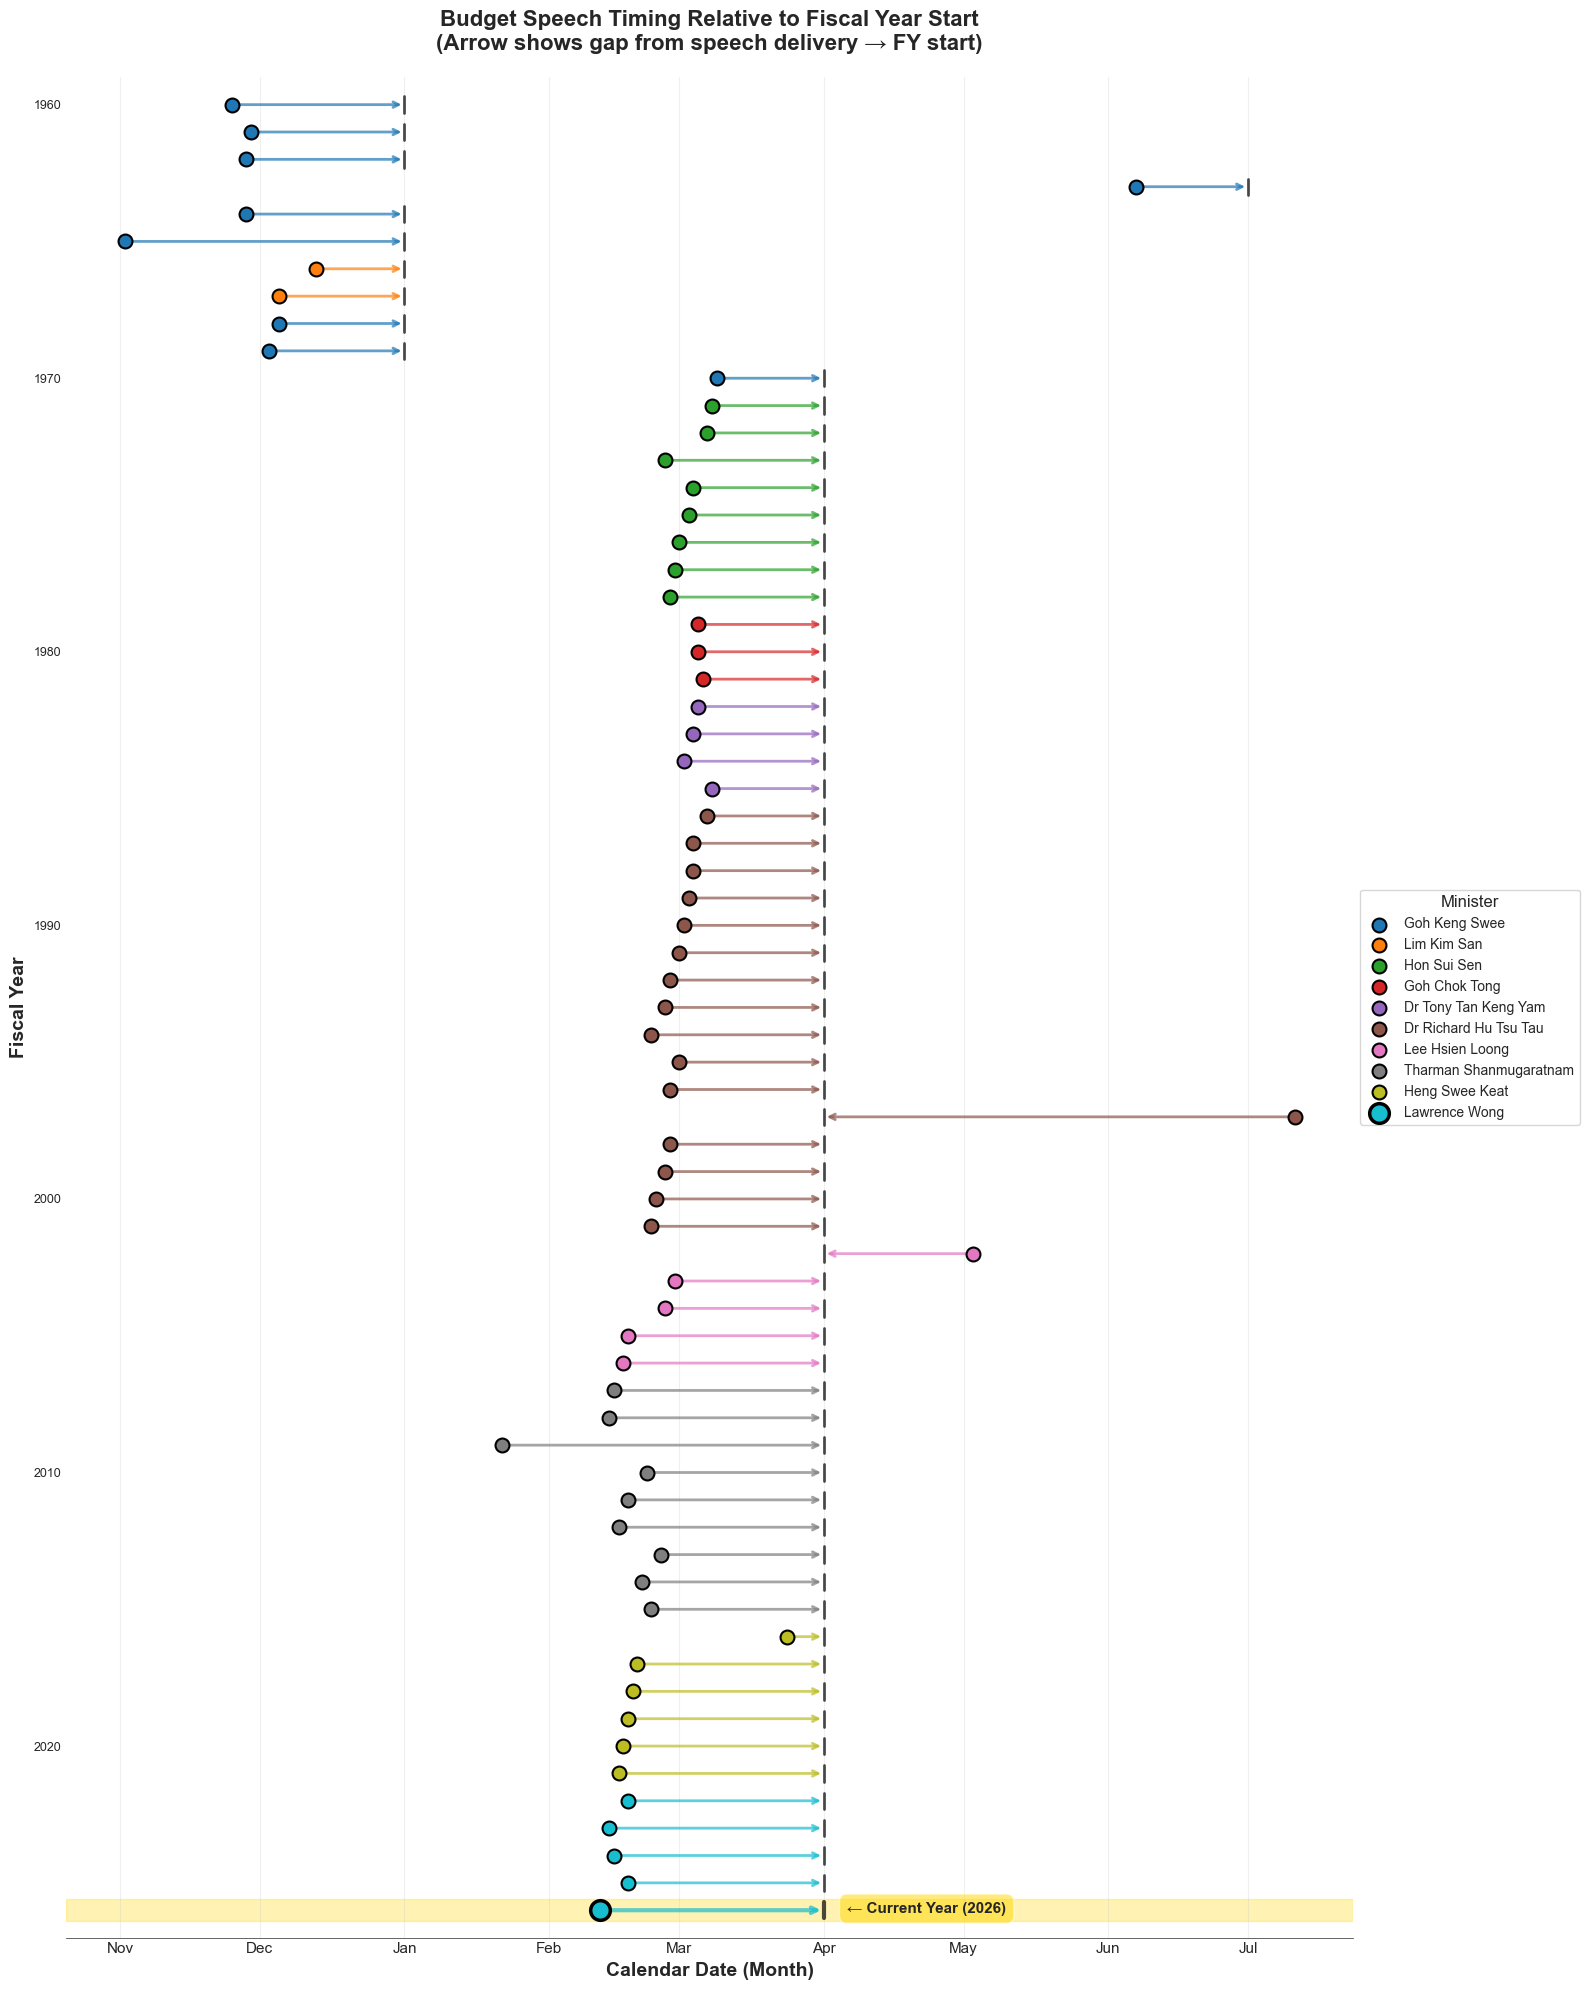

In [33]:
# Create figure
fig, ax = plt.subplots(figsize=(16, 20))

# Plot for each year
for idx, row in df.iterrows():
    year = row['fiscal_year']
    minister = row['minister']
    color = minister_colors[minister]
    
    speech_date = row['speech_date_normalized']
    fy_start = row['fy_start_normalized']
    
    # Highlight 2026 (current year) with background
    if year == 2026:
        # Add yellow background highlight
        ax.axhspan(year - 0.4, year + 0.4, color='gold', alpha=0.3, zorder=0)
        # Use thicker lines and larger markers for 2026
        line_width = 3
        scatter_size = 200
        edge_width = 2.5
    else:
        line_width = 2
        scatter_size = 100
        edge_width = 1.5
    
    # Plot vertical line for fiscal year start
    ax.plot([fy_start, fy_start], [year - 0.3, year + 0.3], 
            color='black', linewidth=line_width, alpha=0.7, zorder=1)
    
    # Plot dot for speech date
    ax.scatter([speech_date], [year], s=scatter_size, color=color, 
               edgecolors='black', linewidth=edge_width, zorder=3, label=minister)
    
    # Plot arrow from speech date to fiscal year start
    ax.annotate('', xy=(fy_start, year), xytext=(speech_date, year),
                arrowprops=dict(arrowstyle='->', color=color, lw=line_width, alpha=0.7),
                zorder=2)
    
# Add annotation for 2026
if year == 2026:
    from datetime import timedelta
    ax.text(fy_start + timedelta(days=5), year + 0.2, '← Current Year (2026)', 
            fontsize=11, fontweight='bold', va='bottom', ha='left',
            bbox=dict(boxstyle='round,pad=0.5', facecolor='gold', alpha=0.5))

# Format x-axis to show months
ax.xaxis.set_major_formatter(mdates.DateFormatter('%b'))
ax.xaxis.set_major_locator(mdates.MonthLocator())
ax.tick_params(axis='x', labelsize=11)
ax.tick_params(axis='y', labelsize=9)

# Set labels and title
ax.set_xlabel('Calendar Date (Month)', fontsize=14, fontweight='bold')
ax.set_ylabel('Fiscal Year', fontsize=14, fontweight='bold')
ax.set_title('Budget Speech Timing Relative to Fiscal Year Start\n(Arrow shows gap from speech delivery → FY start)', 
             fontsize=16, fontweight='bold', pad=20)

# Set y-axis
ax.set_ylim(df['fiscal_year'].min() - 1, df['fiscal_year'].max() + 1)
ax.invert_yaxis()  # Latest year at top

# Grid
ax.grid(True, alpha=0.3, axis='x')

# Legend - remove duplicates
handles, labels = ax.get_legend_handles_labels()
by_label = dict(zip(labels, handles))
ax.legend(by_label.values(), by_label.keys(), 
          title='Minister', loc='center left', bbox_to_anchor=(1, 0.5),
          frameon=True, fontsize=10, title_fontsize=12)

plt.tight_layout()
plt.show()


## Summary Statistics

Calculate key statistics about the timing of budget speeches.

In [34]:
# Display summary statistics
print("=" * 60)
print("OVERALL SUMMARY STATISTICS")
print("=" * 60)
print(f"Average days before fiscal year start: {df['days_before_fy'].mean():.1f}")
print(f"Median days before fiscal year start: {df['days_before_fy'].median():.1f}")
print(f"Min days: {df['days_before_fy'].min()} (Year {df.loc[df['days_before_fy'].idxmin(), 'fiscal_year']})")
print(f"Max days: {df['days_before_fy'].max()} (Year {df.loc[df['days_before_fy'].idxmax(), 'fiscal_year']})")
print(f"Std deviation: {df['days_before_fy'].std():.1f} days")

# Check if any speeches were after FY start (negative values)
after_fy = df[df['days_before_fy'] < 0]
if len(after_fy) > 0:
    print(f"\nSpeeches delivered AFTER fiscal year start: {len(after_fy)}")
    for _, row in after_fy.iterrows():
        print(f"  {row['fiscal_year']}: {abs(row['days_before_fy'])} days after")
else:
    print("\nAll speeches were delivered before the fiscal year start.")

OVERALL SUMMARY STATISTICS
Average days before fiscal year start: 31.4
Median days before fiscal year start: 33.0
Min days: -101 (Year 1997)
Max days: 69 (Year 2009)
Std deviation: 20.5 days

Speeches delivered AFTER fiscal year start: 2
  1997: 101 days after
  2002: 32 days after


## Analysis by Minister

Compare timing patterns across different ministers.

In [35]:
# Statistics by minister
print("\n" + "=" * 60)
print("STATISTICS BY MINISTER")
print("=" * 60)

minister_stats = df.groupby('minister').agg({
    'days_before_fy': ['mean', 'median', 'min', 'max', 'std'],
    'fiscal_year': ['min', 'max', 'count']
}).round(1)

minister_stats.columns = ['Avg Days', 'Median Days', 'Min Days', 'Max Days', 'Std Dev', 'First Year', 'Last Year', 'Count']
minister_stats = minister_stats.sort_values('First Year')

print(minister_stats.to_string())


STATISTICS BY MINISTER
                        Avg Days  Median Days  Min Days  Max Days  Std Dev  First Year  Last Year  Count
minister                                                                                                
Goh Keng Swee               33.4         33.0        23        60     11.1        1960       1970      9
Lim Kim San                 23.0         23.0        19        27      5.7        1966       1967      2
Hon Sui Sen                 29.5         30.0        24        34      3.7        1971       1978      8
Goh Chok Tong               26.7         27.0        26        27      0.6        1979       1981      3
Dr Tony Tan Keng Yam        27.2         27.5        24        30      2.5        1982       1985      4
Dr Richard Hu Tsu Tau       23.6         32.0      -101        37     33.4        1986       2001     16
Lee Hsien Loong             23.8         34.0       -32        43     31.6        2002       2006      5
Tharman Shanmugaratnam      43.

## Analysis by Fiscal Year Period

Compare pre-1970 (Jan-Dec fiscal year) vs post-1970 (Apr-Mar fiscal year).

In [36]:
# Compare pre-1970 vs post-1970
print("\n" + "=" * 60)
print("COMPARISON: PRE-1970 vs POST-1970 FISCAL YEAR CHANGE")
print("=" * 60)

pre_1970 = df[df['fiscal_year'] < 1970]
post_1970 = df[df['fiscal_year'] >= 1970]

print(f"\nPre-1970 (Jan-Dec fiscal year):")
print(f"  Count: {len(pre_1970)}")
print(f"  Average days before FY start: {pre_1970['days_before_fy'].mean():.1f}")
print(f"  Median days before FY start: {pre_1970['days_before_fy'].median():.1f}")

print(f"\nPost-1970 (Apr-Mar fiscal year):")
print(f"  Count: {len(post_1970)}")
print(f"  Average days before FY start: {post_1970['days_before_fy'].mean():.1f}")
print(f"  Median days before FY start: {post_1970['days_before_fy'].median():.1f}")


COMPARISON: PRE-1970 vs POST-1970 FISCAL YEAR CHANGE

Pre-1970 (Jan-Dec fiscal year):
  Count: 10
  Average days before FY start: 32.4
  Median days before FY start: 31.0

Post-1970 (Apr-Mar fiscal year):
  Count: 57
  Average days before FY start: 31.2
  Median days before FY start: 33.0


## Identify Outliers

Find years with unusually early or late speech delivery.

In [39]:
# Find outliers
print("\n" + "=" * 60)
print("OUTLIERS (Top 5 Earliest and Latest)")
print("=" * 60)

# Historical context for outliers
outlier_context = {
    2009: """Global Financial Crisis emergency response: Budget moved forward 
          from usual late February to January 22 to urgently address the 
          deepening global recession following the 2008 financial meltdown.""",
    
    1965: """Post-independence uncertainty: Speech delivered just before 
          separation from Malaysia (August 1965). Early timing reflected 
          uncertain political situation and preparation for potential 
          self-governance.""",
    
    2026: """Current year: Standard February budget timing, 48 days before 
          April 1 FY start. Represents the modern norm for budget speeches.""",
    
    2008: """Pre-crisis positioning: Delivered in mid-February before the 
          global financial crisis fully hit. Economy was still strong, 
          allowing for normal February timing.""",
    
    2023: """Post-pandemic recovery: Budget focused on post-COVID economic 
          recovery and cost of living support. Normal February timing 
          maintained.""",
    
    1997: """⚠️ Asian Financial Crisis + General Election: Budget massively 
          delayed to July AFTER FY started, following March 1997 election. 
          Delay allowed government to assess rapidly developing Asian 
          Financial Crisis that started in Thailand (July 1997).""",
    
    2002: """⚠️ Post-9/11 recession + Election aftermath: Budget delayed to 
          May AFTER FY started, following November 2001 election. Singapore 
          was in severe recession (-2.4% GDP in 2001) due to dot-com crash 
          and 9/11.""",
    
    2016: """Heng Swee Keat's first budget: As newly appointed Finance Minister 
          (September 2015), late March timing (versus usual mid-February) 
          likely gave him more preparation time for his debut budget.""",
    
    1966: """Post-separation transition: First full budget after Singapore's 
          separation from Malaysia (August 9, 1965). Delivered by Lim Kim 
          San just 4 months after independence, late timing reflected 
          political upheaval.""",
    
    1970: """Fiscal year transition: Budget marked Singapore's shift from 
          Jan-Dec to Apr-Mar fiscal year (starting FY1970/71). March 9 
          speech prepared for new April 1 FY start.""",
}

print("\nTop 5 EARLIEST speeches (most days before FY start):")
earliest = df.nlargest(5, 'days_before_fy')[['fiscal_year', 'minister', 'speech_date', 'fy_start_date', 'days_before_fy']]
for _, row in earliest.iterrows():
    year = int(row['fiscal_year'])
    print(f"\n  {year}: {row['days_before_fy']} days before ({row['minister']})")
    print(f"    Speech: {row['speech_date'].strftime('%Y-%m-%d')}, FY Start: {row['fy_start_date'].strftime('%Y-%m-%d')}")
    if year in outlier_context:
        import textwrap
        context_text = textwrap.fill(outlier_context[year], width=70, 
                                     initial_indent='    💡 ', 
                                     subsequent_indent='       ')
        print(context_text)

print("\n\nTop 5 LATEST speeches (fewest days before FY start):")
latest = df.nsmallest(5, 'days_before_fy')[['fiscal_year', 'minister', 'speech_date', 'fy_start_date', 'days_before_fy']]
for _, row in latest.iterrows():
    year = int(row['fiscal_year'])
    print(f"\n  {year}: {row['days_before_fy']} days before ({row['minister']})")
    print(f"    Speech: {row['speech_date'].strftime('%Y-%m-%d')}, FY Start: {row['fy_start_date'].strftime('%Y-%m-%d')}")
    if year in outlier_context:
        import textwrap
        context_text = textwrap.fill(outlier_context[year], width=70, 
                                     initial_indent='    💡 ', 
                                     subsequent_indent='       ')
        print(context_text)


OUTLIERS (Top 5 Earliest and Latest)

Top 5 EARLIEST speeches (most days before FY start):

  2009: 69 days before (Tharman Shanmugaratnam)
    Speech: 2009-01-22, FY Start: 2009-04-01
    💡 Global Financial Crisis emergency response: Budget moved forward
       from usual late February to January 22 to urgently address the
       deepening global recession following the 2008 financial
       meltdown.

  1965: 60 days before (Goh Keng Swee)
    Speech: 1964-11-02, FY Start: 1965-01-01
    💡 Post-independence uncertainty: Speech delivered just before
       separation from Malaysia (August 1965). Early timing reflected
       uncertain political situation and preparation for potential
       self-governance.

  2026: 48 days before (Lawrence Wong)
    Speech: 2026-02-12, FY Start: 2026-04-01
    💡 Current year: Standard February budget timing, 48 days before
       April 1 FY start. Represents the modern norm for budget
       speeches.

  2008: 46 days before (Tharman Shanmugaratnam)